# Deep Q-Network implementation.

In [1]:
# # in google colab uncomment this

import os

os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

os.system('python -m pip install -U pygame --user')

prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/'

os.system('wget ' + prefix + 'atari_wrappers.py')
os.system('wget ' + prefix + 'utils.py')
os.system('wget ' + prefix + 'replay_buffer.py')
os.system('wget ' + prefix + 'framebuffer.py')

print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

setup complete
Starting virtual X frame buffer: Xvfb.


In [2]:
import random
import os

import numpy as np
import torch
import utils

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ENV_NAME = "BreakoutNoFrameskip-v4"

## Preprocessing

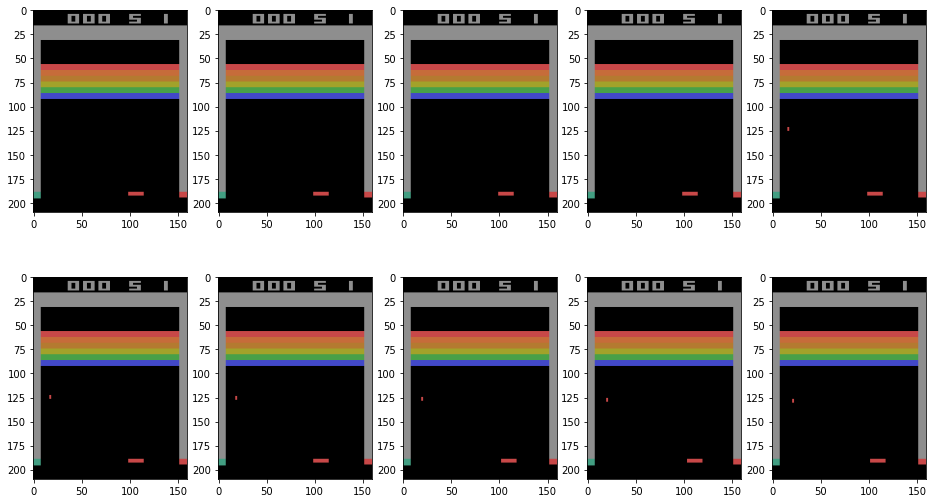

In [5]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        img = env.render('rgb_array')
        ax.imshow(img)
        env.step(env.action_space.sample())
plt.show()

### Processing game image 


In [6]:
import cv2
from gym.core import ObservationWrapper
from gym.spaces import Box


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):

        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        result = np.zeros(self.img_size, dtype=np.float32)
        for ch, w in zip(range(3), channel_weights):
            result[0] += w * rgb[:, :, ch]
        
        return result

    def observation(self, img):
      
        img = img[30:195, 5:154]
        img = cv2.resize(img, self.img_size[1:])
        img = self._to_gray_scale(img)
        img /= 255

        return img

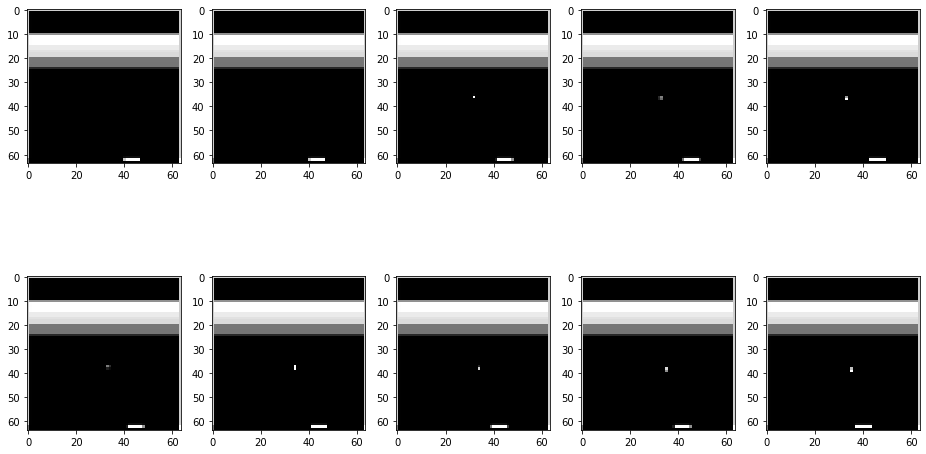

In [7]:
import gym

env = gym.make(ENV_NAME)
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Wrapping.

In [8]:
%load_ext autoreload
%autoreload 2
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.EpisodicLifeEnv(env)
    env = atari_wrappers.FireResetEnv(env)
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)
    env = PreprocessAtariObs(env)
    return env

### Frame buffer

In [9]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

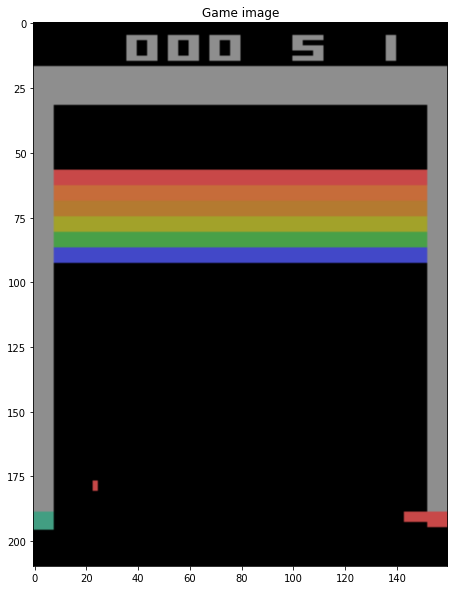

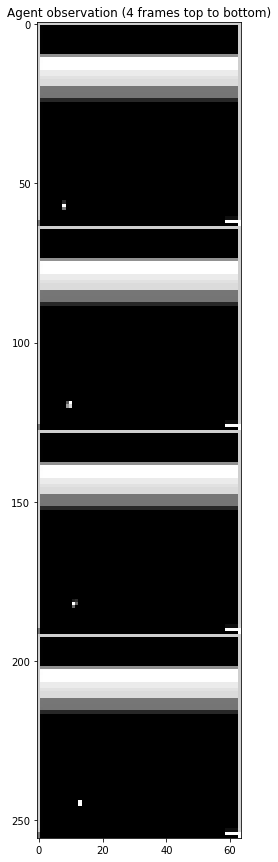

In [10]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

## DQN

### Building a network

In [11]:
import torch
from torch import nn

In [12]:
device = torch.device('cuda')

In [13]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

In [14]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        lin_input = state_shape[1]
        
        for _ in range(3):
            lin_input = conv2d_size_out(lin_input, 3, 2)
        lin_input = 64 * lin_input ** 2

        self.network = nn.Sequential(
            nn.Conv2d(4, 16, 3, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(lin_input, 256),
            nn.Linear(256, n_actions)
        )
        

    def forward(self, state_t):
        qvalues = self.network(state_t)

        return qvalues

    def get_qvalues(self, states):

        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):

        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [15]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [16]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):

    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [17]:
evaluate(env, agent, n_games=100)

0.38

### Experience replay

In [18]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

In [19]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    
    s = initial_state
    sum_rewards = 0

    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        s_next, r, done, _ = env.step(action)
        sum_rewards += r
        exp_replay.add(s, action, r, s_next, done)
        if done:
            s = env.reset()
        else:
            s = s_next

    return sum_rewards, s

### Target networks

In [20]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Q-learning

In [21]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):

    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    predicted_qvalues = agent(states)
    predicted_next_qvalues = target_network(next_states)

    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    target_qvalues_for_actions = rewards + gamma * next_state_values
    target_qvalues_for_actions = (is_done * rewards) + (is_not_done * target_qvalues_for_actions)

    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

In [22]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

## Main loop

In [23]:
from tqdm import trange
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [25]:
seed = 42
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [26]:
exp_replay = ReplayBuffer(10**4)
for i in tqdm(range(100)):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    _, _, = play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break

print(len(exp_replay))

10000


In [27]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [28]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

buffer size = 10000, epsilon = 0.61750


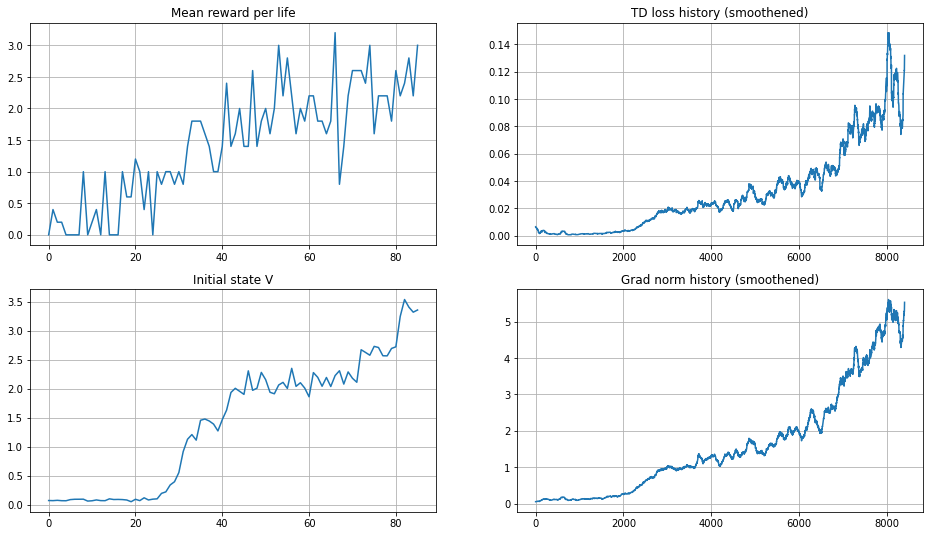

KeyboardInterrupt: ignored

In [29]:
state = env.reset()

try:
  for step in range(step, total_steps + 1):
      if not utils.is_enough_ram():
          print('less that 100 Mb RAM available, freezing')
          print('make sure everythin is ok and make KeyboardInterrupt to continue')
          try:
              while True:
                  pass
          except KeyboardInterrupt:
              pass

      agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

      _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

      obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

      loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                            agent, target_network,
                            gamma=0.99, check_shapes=True)

      loss.backward()
      grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
      opt.step()
      opt.zero_grad()

      if step % loss_freq == 0:
          td_loss_history.append(loss.data.cpu().item())
          grad_norm_history.append(grad_norm)

      if step % refresh_target_network_freq == 0:
          target_network.load_state_dict(agent.state_dict())

      if step % eval_freq == 0:
          mean_rw_history.append(evaluate(
              make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
          )
          initial_state_q_values = agent.get_qvalues(
              [make_env(seed=step).reset()]
          )
          initial_state_v_history.append(np.max(initial_state_q_values))

          clear_output(True)
          print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

          plt.figure(figsize=[16, 9])

          plt.subplot(2, 2, 1)
          plt.title("Mean reward per life")
          plt.plot(mean_rw_history)
          plt.grid()

          assert not np.isnan(td_loss_history[-1])
          plt.subplot(2, 2, 2)
          plt.title("TD loss history (smoothened)")
          plt.plot(utils.smoothen(td_loss_history))
          plt.grid()

          plt.subplot(2, 2, 3)
          plt.title("Initial state V")
          plt.plot(initial_state_v_history)
          plt.grid()

          plt.subplot(2, 2, 4)
          plt.title("Grad norm history (smoothened)")
          plt.plot(utils.smoothen(grad_norm_history))
          plt.grid()

          plt.show()
except KeyboardInterrupt:
  pass

## Result

In [30]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)

final score: 19.0


### Video

In [31]:
# record sessions
import gym.wrappers

env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]
env_monitor.close()

In [32]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices